# NOTEBOOK 6: CLASSIFICATION - SVM 
### Team 3
- Anjali Sebastian
- Yesha Sharma
- Rupansh Phutela

### What this Notebook does?
After Data selection, cleaning, pre-processing, EDA and Regression Analysis, Clustering, and Gaussian Naive Bayes Classification and Neural Networks usinng MLP, we will now look at how we can perform SVM classfication on our data. Our data has target varibale y = Diabetes (Yes or No) we will try to classify the data to see the performance of different classifiers. In this Notebook we are trying various **Support Vector Machine** Classification Models.

 - Normalization of entire dataset due to varying ranges of different attributes
 - Feature Importances - Identify Best Features
 - Use Principle Component Analysis to reduce dimensionality of the best selected features
 - Multiple SVM models (Linear and RBF). Find good C and Gamma Parameter
 - Analysis of the Best SVM Model in terms of metrics, confusion matrix, classification report and ROC Curve 
 - Conclusion
 - References

## 1. Import Packages and Setup

In [1]:
# you need   Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
import os
import pandas as pd   
import numpy as np    
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
##############################################

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# method to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 2. Utility Functions

In [5]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00','#00AAFF','#000000','#FF00AA','#2ca02c', '#d62728','#9467bd','#8c564b','#e377c2']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

In [6]:
# a function to plot a bar graph of important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    #plt.figure(figsize=(15,4))
    plt.figure(figsize=(8,8))
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

In [7]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

In [8]:
# Show confusion matrix
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 3. Read Data and Display

In [9]:
diabetes = pd.read_csv('./diabetes.csv')

In [10]:
diabetes.head()

,Unnamed: 0,Diabetes,BMI,State,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0,0.0,28.17,AL,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,1,0.0,18.54,AL,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,2,1.0,31.62,AL,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,6,1.0,32.98,AL,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,9,1.0,16.65,AL,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [11]:
#set datatypes of columns to boolean or categorical as appropriate
make_bool_int = ['Diabetes','HighBP','HighChol','CholCheck',\
             'FruitConsume','VegetableConsume','Smoker','HeavyDrinker','Stroke','HeartDisease',\
             'Healthcare','NoDoctorDueToCost','PhysicalActivity','DifficultyWalking','Gender']
make_categorical_int = ['GeneralHealth','Age','Education','Income']

In [12]:
#drop the extra index column in datafram
diabetes=diabetes.drop(['Unnamed: 0'], axis=1)

#drop the state column in dataframe since it will not be used in the dataframe
diabetes=diabetes.drop(['State'], axis=1)

In [13]:
diabetes.head()

,Diabetes,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.0,28.17,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,0.0,18.54,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,1.0,31.62,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,1.0,32.98,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,1.0,16.65,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [14]:
# deep copy before next stage
df = diabetes.copy(deep = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243317 entries, 0 to 243316
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Diabetes           243317 non-null  float64
 1   BMI                243317 non-null  float64
 2   HighBP             243317 non-null  float64
 3   HighChol           243317 non-null  float64
 4   CholCheck          243317 non-null  float64
 5   FruitConsume       243317 non-null  float64
 6   VegetableConsume   243317 non-null  float64
 7   Smoker             243317 non-null  float64
 8   HeavyDrinker       243317 non-null  float64
 9   Stroke             243317 non-null  float64
 10  HeartDisease       243317 non-null  float64
 11  Healthcare         243317 non-null  float64
 12  NoDoctorDueToCost  243317 non-null  float64
 13  PhysicalActivity   243317 non-null  float64
 14  GeneralHealth      243317 non-null  float64
 15  PhysicalHealth     243317 non-null  float64
 16  Me

In [16]:
df.shape

(243317, 22)

## 4. Normalization and Simple Vizualization

In [17]:
X_columns = ['BMI', 'HighBP', 'HighChol', 'CholCheck', 'FruitConsume',
       'VegetableConsume', 'Smoker', 'HeavyDrinker', 'Stroke', 'HeartDisease',
       'Healthcare', 'NoDoctorDueToCost', 'PhysicalActivity', 'GeneralHealth',
       'PhysicalHealth', 'MentalHealth', 'DifficultyWalking', 'Gender', 'Age',
       'Education', 'Income']

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Not Normalized')

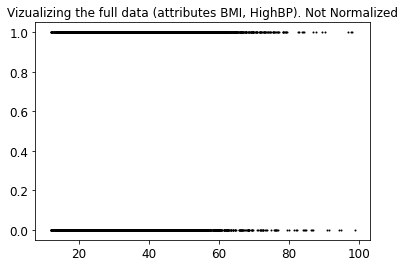

In [18]:
# separating the target column y = Diabetes before classification
# for complete dataset
X_df = df[X_columns].values
y_df = df[['Diabetes']]
plot_data(X_df)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Not Normalized")

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Normalized')

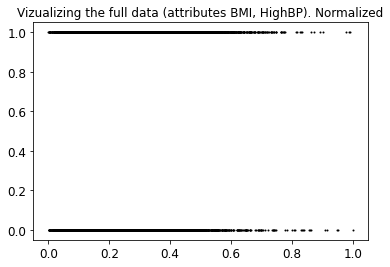

In [19]:
# Using minmax scaler for normalization
from sklearn.preprocessing import MinMaxScaler

# normalization full dataset
X_normalized = MinMaxScaler().fit(X_df).transform(X_df)
df_normalized = pd.DataFrame(X_normalized, columns=X_columns )
plot_data(X_normalized)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Normalized")

Note: The data pairs are as follows:
- Full Data
    1. X_df (pandas) with y_df(pandas) : not normalized full data set
    2. X_normalized (numpy) with y_df(pandas) : normalized full X in numpy (easy for clustering)
    3. df_normalized (pandas) with y_df(pandas) : normalized X in pandas format (easy for tracking feature names)
    
- For all our classification we will use only the normalized versions of the dataset.
- We will first pick the best features flowing which we will use PCA to reduce dataset to 2 features

##  5. Feature Importances - With Decision Tree Classifier
- We are using Decision Tree Classifier to find which features are more important  to see which features are having the highestimpact on our target.
- We will only be using normalized data. Since it will put all features in similar range.  
- We will be using the full dataset as is . We will also we using a balanced version of the dataset using undersampling technique to see if there is any change in the key features.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [21]:
X = X_normalized
y_df['Diabetes']=y_df['Diabetes'].astype('int')
y = y_df.to_numpy()

In [22]:
# A simple training (1 training)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.30)

#### Using Full Dataset As Is

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.79


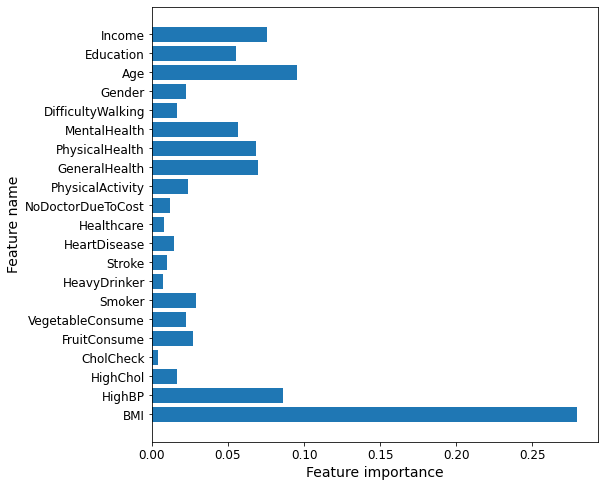

Feature importances: [0.27931751 0.08635461 0.01666336 0.00396084 0.02698384 0.02236237
 0.02883552 0.00744351 0.00987176 0.01420467 0.0082121  0.01204351
 0.02342647 0.06937859 0.06842486 0.05683353 0.01673057 0.02241037
 0.09529659 0.05551182 0.0757336 ]


In [23]:
clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Accuracy of DT classifier on training set: {:.2f}'.format(train_score))
print('Accuracy of DT classifier on test set: {:.2f}'.format(test_score))


# import features (call the function above)
plot_feature_importances(clf, df_normalized.columns)

plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

In [24]:
clf.score(X_test, y_test)

0.7932900432900433

In [25]:
y_pred = clf.predict(X_test)

#  confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[54468,  8045],
       [ 7044,  3439]], dtype=int64)

In [26]:
# Print classification report
target_names = ['Class 0', 'Class 1']

result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print(result_metrics)

              precision    recall  f1-score   support

     Class 0       0.89      0.87      0.88     62513
     Class 1       0.30      0.33      0.31     10483

    accuracy                           0.79     72996
   macro avg       0.59      0.60      0.60     72996
weighted avg       0.80      0.79      0.80     72996



#### Doing with a Balanced Dataset 
- using random undersampler only on the training part  

In [27]:
# import RandomUndersampler
from imblearn.under_sampling import RandomUnderSampler

In [28]:
X_train.shape

(170321, 21)

In [29]:
under = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = under.fit_resample(X_train, y_train)

In [30]:
X_train.shape

(49632, 21)

In [31]:
unique, counts = np.unique(y_train, return_counts=True)
print ( np.asarray((unique, counts)).T)

[[    0 24816]
 [    1 24816]]


Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.66


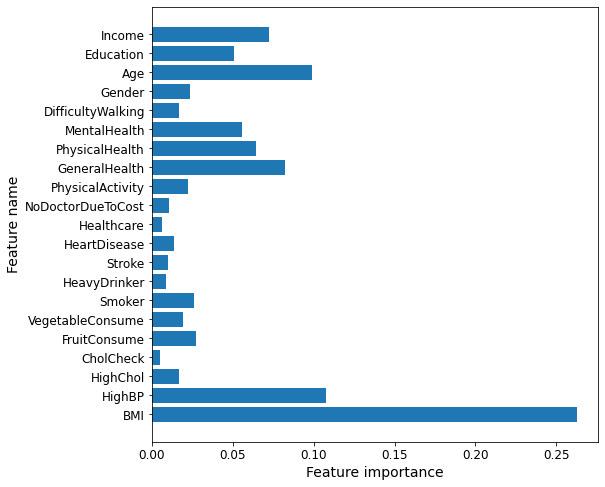

Feature importances: [0.26291005 0.10754319 0.01688605 0.00499179 0.02712826 0.01928236
 0.02616177 0.00840229 0.00992798 0.01337396 0.0062639  0.01041017
 0.02246018 0.0820788  0.06436261 0.05540956 0.01649228 0.02356799
 0.09920803 0.05057206 0.0725667 ]


In [32]:
clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Accuracy of DT classifier on training set: {:.2f}'.format(train_score))
print('Accuracy of DT classifier on test set: {:.2f}'.format(test_score))

#plt.figure(figsize=(12,12), dpi=60)

# import features (call the function above)
plot_feature_importances(clf, df_normalized.columns)

plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

In [33]:
clf.score(X_test, y_test)

0.6602553564578881

In [34]:
y_pred = clf.predict(X_test)

#  confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[41328, 21185],
       [ 3615,  6868]], dtype=int64)

In [35]:
# Print classification report
target_names = ['Class 0', 'Class 1']

result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print(result_metrics)

              precision    recall  f1-score   support

     Class 0       0.92      0.66      0.77     62513
     Class 1       0.24      0.66      0.36     10483

    accuracy                           0.66     72996
   macro avg       0.58      0.66      0.56     72996
weighted avg       0.82      0.66      0.71     72996



Note: Looking at at the feature importance we can see that the bar plots for both the original dataset and the balanced data set are having similar patterns. We see that the following 8 features are very important  -  BMI, HighBP, General Health, Physical Health, Mental Health, Age , Education and Income.     

In [36]:
# Create a list of important features
important_features = ['BMI','HighBP','GeneralHealth','PhysicalHealth','MentalHealth','Age','Education','Income']

## 5. Principle Component Analysis
- Using the only the most important features dicovered from the decision tree model we reduce the dimensionality to 2 using Principal Component Analysis 

In [37]:
df_normalized.head()

,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,HeartDisease,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.186505,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.50,0.500000,0.0,1.0,0.0,1.000000,0.4,0.285714
1,0.075433,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.25,0.333333,0.0,0.0,0.0,0.833333,0.8,0.571429
2,0.226298,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.50,0.000000,1.0,1.0,0.0,0.750000,1.0,0.857143
3,0.241984,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.75,1.000000,0.0,1.0,1.0,0.833333,1.0,0.857143
4,0.053633,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.666667,0.0,1.0,0.0,0.833333,0.2,0.285714


In [38]:
# Choose True if we are selecting only 8 top features for doing PCA else it will take entire data set
select_features = True

if(select_features==True):
    df_best_features = df_normalized[important_features]
else:
    df_best_features = df_normalized
df_best_features.head()

,BMI,HighBP,GeneralHealth,PhysicalHealth,MentalHealth,Age,Education,Income
0,0.186505,1.0,0.50,0.500000,0.0,1.000000,0.4,0.285714
1,0.075433,0.0,0.25,0.333333,0.0,0.833333,0.8,0.571429
2,0.226298,1.0,0.50,0.000000,1.0,0.750000,1.0,0.857143
3,0.241984,0.0,0.75,1.000000,0.0,0.833333,1.0,0.857143
4,0.053633,0.0,0.00,0.666667,0.0,0.833333,0.2,0.285714


In [39]:
# Dimesionality reduction to 2
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
pca_model.fit(df_best_features) # fit the model
X_normalized_pca = pca_model.transform(df_best_features)
X_normalized_pca

array([[ 0.8143773 ,  0.21944804],
       [-0.1775784 ,  0.39799483],
       [ 0.57868681, -0.00386865],
       ...,
       [-0.3079835 ,  0.39221926],
       [-0.47663154,  0.34781812],
       [-0.51515748, -0.06059107]])

In [40]:
# numpy 
X_normalized_pca.shape

(243317, 2)

In [41]:
# panda it 
df_X_normalized_pca = pd.DataFrame(X_normalized_pca, columns=['Feature1','Feature2'] )
df_X_normalized_pca.head()

,Feature1,Feature2
0,0.814377,0.219448
1,-0.177578,0.397995
2,0.578687,-0.003869
3,-0.225108,0.374260
4,0.051858,0.924369


Note: We have reduced our datasets dimensionality to 2 features which have just been named feature1 and feature2. Going ahead we will be using these two synthetic features to perform our classification.

## 6. Support Vector Machines
- SVM is a very slow algorithmn since it is very computationaly intensive so we will take only a part of the dataset to run the classification on  (around 10,000) 
- For Support Vector Machines we will try different X variables and classify the diabetics/non-diabetics.

In [42]:
# attach back the labels before sampling
df_normalized_pca = pd.concat([df_X_normalized_pca.reset_index(drop=True), y_df.reset_index(drop=True)], axis= 1)
df_normalized_pca.head()

,Feature1,Feature2,Diabetes
0,0.814377,0.219448,0
1,-0.177578,0.397995,0
2,0.578687,-0.003869,1
3,-0.225108,0.374260,1
4,0.051858,0.924369,1


In [43]:
# Selecting a random sample for the data set
#sampling a random number of values since svm classification of all 0.2 million datapoints is too slow
# option 10000 , 50000 etc.
number_of_samples = 10000
sample_normalized_pca = df_normalized_pca.sample(number_of_samples, random_state=42)

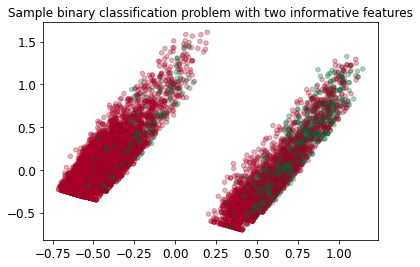

In [44]:
# plotting the 2 attributes of PCA
plt.figure()
plt.title('Sample binary classification problem with two informative features')

#Plotting just sample points to not clutter the scatter plot
plt.scatter(sample_normalized_pca.iloc[:, 0], sample_normalized_pca.iloc[:, 1], alpha = 0.3,cmap=plt.cm.RdYlGn,marker= 'o', s=20, c=sample_normalized_pca.loc[:,'Diabetes'])
plt.show()

In [45]:
# set up the Data 
X = sample_normalized_pca.iloc[:,[0,1]].to_numpy()
y = sample_normalized_pca.iloc[:,[2]].to_numpy()
print(X.shape)

(10000, 2)


In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

# undersampling only on the Training sets 
under = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = under.fit_resample(X_train, y_train)
print(X_train.shape)

(2194, 2)


### MODEL 1: Linear Kernal
- We are using normalized data that was transformed by PCA to 2 features
- We will use under sampling technique since we are more interested in positive cases
- We only undersample the training sets because the model needs to perform with naturally imbalanced data (ie less positive diabetes cases) we leave the test sets as they are.

In [47]:
clf1 = SVC(kernel = 'linear', C=1.0,random_state=42).fit(X_train, y_train)

y_pred = clf1.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print(result_metrics)


              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2103
           1       0.29      0.77      0.42       397

    accuracy                           0.66      2500
   macro avg       0.61      0.71      0.59      2500
weighted avg       0.83      0.66      0.70      2500



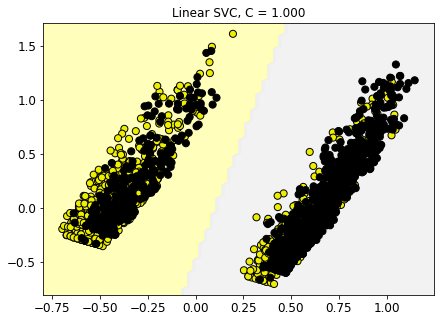

In [48]:
# plot the classifier
fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))

title = 'Linear SVC, C = {:.3f}'.format(1.0)
plot_class_regions_for_classifier_subplot(clf1, X_train, y_train, None, None, title, subaxes)

Note: As previously seen during EDA and Regression. Linear Models are not able to generate good results. We will try with the RBF kernal next.

### MODEL 2: RBF Kernal
- We are using normalized data that was transformed by PCA to 2 features
- We will use under sampling technique since we are more interested in positive cases

In [49]:
clf2 = SVC(kernel='rbf', max_iter=10000,random_state=42).fit(X_train, y_train)
y_pred = clf2.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print('RBF kernel (Gaussian) results\n', result_metrics)

RBF kernel (Gaussian) results
               precision    recall  f1-score   support

           0       0.94      0.71      0.81      2103
           1       0.33      0.74      0.45       397

    accuracy                           0.72      2500
   macro avg       0.63      0.73      0.63      2500
weighted avg       0.84      0.72      0.75      2500



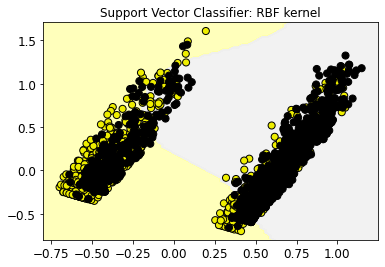

In [50]:
# The default SVC kernel is radial basis function (RBF)
plot_class_regions_for_classifier(clf2.fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'Support Vector Classifier: RBF kernel')

### MODEL 3: RBF Kernal with varying C and Gamma Parameter
- Apply SVM RBF kernel using varying C and gamma parameter values.
- Use C= 0.1, 1, 15, 250. Use gamma= 0.01, 1, 5.
- Hence, 12 subplots, similar to the above example, should be drawn.
- Note we continue to use normalized, dimension reduced feature . We have take a small sample of the total data as SVM is very computation intensive

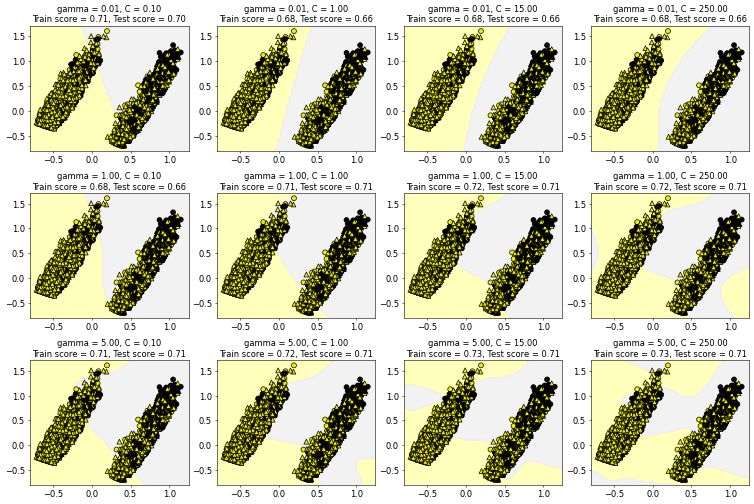

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):
    
    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(this_gamma, this_C)
        clf = SVC(kernel = 'rbf', gamma = this_gamma,
                 C = this_C,random_state=42).fit(X_train, y_train)
        plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                                 X_test, y_test, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Note: Looking at various Gamma and C values the following look best
- gamma =5 , c= 1
- gamma = 5 , c=15
Too high value of C is causes possible overfit and even with high train score the test score is not better.

In [52]:
clf3 = SVC(kernel='rbf', max_iter=10000, gamma=5,C=1,random_state=42 ).fit(X_train, y_train)
y_pred = clf3.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print('RBF kernel (Gaussian) results\n', result_metrics)

RBF kernel (Gaussian) results
               precision    recall  f1-score   support

           0       0.94      0.70      0.80      2103
           1       0.32      0.75      0.45       397

    accuracy                           0.71      2500
   macro avg       0.63      0.72      0.62      2500
weighted avg       0.84      0.71      0.74      2500



In [53]:
clf4 = SVC(kernel='rbf', max_iter=10000, gamma=5,C=15,random_state=42  ).fit(X_train, y_train)
y_pred = clf4.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print('RBF kernel (Gaussian) results\n', result_metrics)


RBF kernel (Gaussian) results
               precision    recall  f1-score   support

           0       0.94      0.70      0.80      2103
           1       0.32      0.76      0.45       397

    accuracy                           0.71      2500
   macro avg       0.63      0.73      0.63      2500
weighted avg       0.84      0.71      0.74      2500



Note: Gamma =5 and C=15 looks like the best option. The precision value class 1 across all models is poor. However recall for class 1 diabetes = 76 is ok. We will look at this model in more detail in the next section including plotting its ROC curve.   

### MODEL 4: BEST SVM MODEL - RBF Kernal with  C =15 and Gamma = 5
- Note we continue to use normalized, dimension reduced feature . We have take a small sample of the total data as SVM is very computation intensive
- Vizualize the Model
- Metrics: Score , Confusion Matrix, Classification Report
- ROC and AUC curve

In [54]:
clf_best = SVC(kernel='rbf', max_iter=10000, gamma=5, C=15, probability =True , random_state=42).fit(X_train, y_train)
y_pred = clf_best.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print('RBF kernel (Gaussian) results\n', result_metrics)

RBF kernel (Gaussian) results
               precision    recall  f1-score   support

           0       0.94      0.70      0.80      2103
           1       0.32      0.76      0.45       397

    accuracy                           0.71      2500
   macro avg       0.63      0.73      0.63      2500
weighted avg       0.84      0.71      0.74      2500



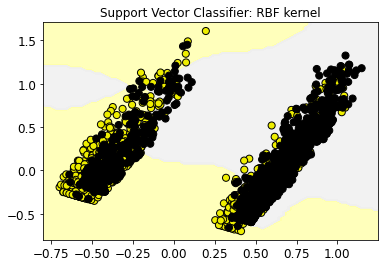

In [55]:
# Plot the classifier
plot_class_regions_for_classifier(clf_best.fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'Support Vector Classifier: RBF kernel')

In [56]:
#Score
print(" Score for the SVM Model = ",clf_best.score(X_test, y_test))

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print('\n Confusion Matrix: \n')
print(confusion_mat)

# Print classification report
target_names = ['Class 0', 'Class 1']
result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print('\n Classification Report: \n')
print(result_metrics)

 Score for the SVM Model =  0.7072

 Confusion Matrix: 

[[1468  635]
 [  97  300]]

 Classification Report: 

              precision    recall  f1-score   support

     Class 0       0.94      0.70      0.80      2103
     Class 1       0.32      0.76      0.45       397

    accuracy                           0.71      2500
   macro avg       0.63      0.73      0.63      2500
weighted avg       0.84      0.71      0.74      2500



Accuracy (AUC) =  0.7685051102479247


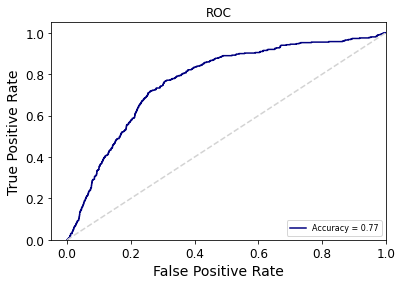

In [57]:
from sklearn.metrics import roc_curve, auc
y_score = clf_best.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)
print('Accuracy (AUC) = ', roc_auc)

count = 1

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
            'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
            'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
            'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']
color = colorSet[count-1]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 8. Relating SVM Classifier and Mini Batch KMeans Clustering

Among all three classifiers ie (Neural Networks, Naive Bayes and SVM ) SVM classifier with RBF produced the best results. We will use the SVM classifier with RBF Kernal, C = gamma=5, C=15 and compare it with our KMeans Mini Batch Cluster Model to see if we can relate any results between the two.

In [58]:
best_classifier = clf_best

In [59]:
df_normalized_pca.head()

,Feature1,Feature2,Diabetes
0,0.814377,0.219448,0
1,-0.177578,0.397995,0
2,0.578687,-0.003869,1
3,-0.225108,0.374260,1
4,0.051858,0.924369,1


In [60]:
#Use the classifier to predict over the entire dataset
classifier_predict  = best_classifier.predict(df_normalized_pca.iloc[:,[0,1]].to_numpy())

In [61]:
classifier_predict.shape

(243317,)

In [62]:
classifier_predict

array([1, 1, 1, ..., 0, 0, 0])

In [63]:
# concat the classifier labels 
df_temp = pd.DataFrame(classifier_predict, columns=["Classifier_Labels"] )
df_compare = pd.concat([df_normalized_pca.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
df_compare.head()

,Feature1,Feature2,Diabetes,Classifier_Labels
0,0.814377,0.219448,0,1
1,-0.177578,0.397995,0,1
2,0.578687,-0.003869,1,1
3,-0.225108,0.374260,1,1
4,0.051858,0.924369,1,1


In [64]:
# Do clustering of the entire dataset using minibatch kmeans , batch size = 32, n_cluster = 2
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=32, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

MiniBatchKMeans(batch_size=32, n_clusters=2, random_state=0)

In [65]:
# concat the cluster labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_compare = pd.concat([df_compare.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
df_compare.head()

,Feature1,Feature2,Diabetes,Classifier_Labels,Cluster_Labels
0,0.814377,0.219448,0,1,1
1,-0.177578,0.397995,0,1,0
2,0.578687,-0.003869,1,1,1
3,-0.225108,0.374260,1,1,1
4,0.051858,0.924369,1,1,1


Text(0.5, 1.0, 'Scatter Plot Marking Labels Generated by clustering')

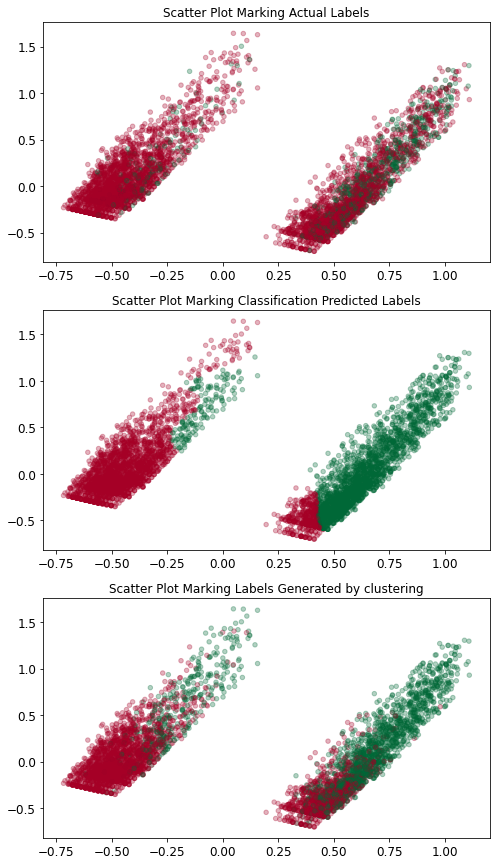

In [66]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, figsize = (8,15))

ax1.scatter(df_compare.iloc[:5000, 0], df_compare.iloc[:5000, 1], alpha = 0.3,cmap=plt.cm.RdYlGn,marker= 'o', 
            s=20, c=df_compare.loc[:4999,'Diabetes'])

ax1.set_title("Scatter Plot Marking Actual Labels")


ax2.scatter(df_compare.iloc[:5000, 0], df_compare.iloc[:5000, 1], alpha = 0.3,cmap=plt.cm.RdYlGn,marker= 'o', 
            s=20, c=df_compare.loc[:4999,'Classifier_Labels'])
ax2.set_title("Scatter Plot Marking Classification Predicted Labels")


ax3.scatter(df_compare.iloc[:5000, 0], df_compare.iloc[:5000, 1], alpha = 0.3,cmap=plt.cm.RdYlGn,marker= 'o', 
            s=20, c=df_compare.loc[:4999,'Cluster_Labels'])
ax3.set_title("Scatter Plot Marking Labels Generated by clustering")


### Quanitfying the results of accuracy

In [67]:
correct_positive =  df_compare.loc[(df_compare['Diabetes'] == df_compare['Cluster_Labels'])&(df_compare['Diabetes'] == 1) ,:]
total_known_positive = df_compare.loc[df_compare['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals for clusterts", percentage_positive)


#Comparison of Classifier Labels

correct_positive_cls =  df_compare.loc[(df_compare['Diabetes'] == df_compare['Classifier_Labels'])&(df_compare['Diabetes'] == 1) ,:]
total_known_positive_cls = df_compare.loc[df_compare['Diabetes'] == 1 ,:]
percentage_positive = correct_positive_cls.shape[0]/total_known_positive_cls.shape[0]
print("Total Percentage of positive over actuals for classifier", percentage_positive)

Total Percentage of positive over actuals for clusterts 0.648941896371002
Total Percentage of positive over actuals for classifier 0.7454035525085696


As we can observe there is a little difference of ~ 10 percent between the results of classifier i.e 0.65 and the results of clustering i.e. 0.745 (Classifier being the better one). But it somehow confirms our assumption of the label during the clustering. This is a good sign that the classifier and the clustering algorithm are trying to derive the labels with some level of accuracy.

# Conclusion

- SVM is a very slow algorithmn since it is very computationaly intensive so we will take only a part of the dataset to run the classification on (around 10,000)
- We decided to use PCA since our dataset had 21 dimensions and although 21 dimensions is not very large by reducing to two dimensions we can understand and visualize the classifier better.
- We decided to not use all the 21 features since some features clearly were not contributing to better models as seen in Regression and Scatter Plot . So to decide which features to keep we used the decision tree classifier. We used this classifier since it is computationaly faster and is more explainable. The 8 key features ['BMI','HighBP','GeneralHealth','PhysicalHealth','MentalHealth','Age','Education','Income'] were then reduced to 2 using Principal Component Analysis
- Our Dataset is significantly imbalanced with positive class "Diabetes = Yes" is the minority. We are interested in catching positive cases. The classification reports show that Recall for class1 =  0.76 which is good but the precision is very low at 0.32. The model tends to generate many false positives.
- We are only showing models trained using undersampling since models without any sort of undersampling yield very low precision/ recall for class 1.  
- Linear Kernel SVM is not able to generate good results
- SVM classifier is able to model non-linear decision boundaries. The model has a reasonable AUC = 0.77. Best Model has hyperparameters C= 15 Gamma = 5 with RBF Kernal.
- Finally we tried to compare the classifier and clustering results which shows that the clustering performance is around 0.65 and the classifier performance is about 0.745. 

# Classification Conclusion

For all the algorithms we studied, We began the classification with 21 features not all of which are meaningful to the classification. Hence we decided to get the feature importances using Decision Tree classifier first and reduced the features to be analyzed as 6. We further used Principal component analysis and reduced it to 2 features. Further, facing another issue of an imbalanced dataset i.e. 90 percent of non-diabetic and 10 percent of diabetic, we undersampled the majority class to bring it in terms with the minority class. All the algorithms were applied to the outcome of undersampled data. 

Gaussian Naive Bayes got us a model a model with AUC as 0.76 which looked promising but the precision of the model was way less at 0.24 hence a lot of false negatives. Even with tuning hyper parameters such as Stratified K Fold and var_smoothing, there wasn't significant improvement. Hence we went to another classifier based on neural networks

The next two algorithms were computationally expensive and only a part of data was used to do further analysis.

We tried tuning the MLP Classifier for the diabetes dataset. The best neural network model turned out to be the one with  5 layers with 100 neurons in each layer, with Regularization alpha = 1 using The RELU activation function. The classifier reported Recall score for class 1 (minority) = 0.73 but the precision is very low at 0.31 tending to generate many false positives.

The last classifier in our tests was the Support Vector Classifier. SVM classifier is able to model non-linear decision boundaries. The model has a reasonable AUC = 0.77. Best Model has hyperparameters C= 15 Gamma = 5 with RBF Kernal.The classifier reported Recall for class 1 = 0.76 which is good but the precision is very low at 0.32. 

Though there wasn't a lot to choose from the MLP but SVM performed the best among the various permutations and combinations of algorithms, our dataset and the hyper parameter tuning that we tried.

Also we observe that the comparison of best SVM model and best Clustering (Mini Batch K-Means) predicting the labels have some level of accuracy (Classifier  - 0.745, CLustering - 0.65) and somehow confirms our assumption in the Clustering sheet.

# REFERENCES 

https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet
https://mclguide.readthedocs.io/en/latest/sklearn/clusterdim.html
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability
https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data


Material from Machine Learning Course, Seattle University  

Material from Introduction to Data Science, Seattle University  

# --END PROJECT--
